In [1]:
import intake
import pandas as pd
import numpy as np
import yaml
from scipy.signal import stft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Data Source Examples

This notebook contains example plots of data from different diagnostics as a demonstration of what sort data is available in the archive. 

In [2]:
with open('config.yml') as file_handle:
    config = yaml.load(file_handle, yaml.FullLoader)

HOST_URL = config['host']

## Setup

First we need to find the url to a particualr shot. Here we are going to use shot 30420 as an example.

In [3]:
shot_id = 30420
catalog  = intake.open_catalog(f'{HOST_URL}/intake/catalog.yml')
shot_df = pd.DataFrame(catalog.index.level1.shots().read())
url = shot_df.loc[shot_df.shot_id == shot_id].iloc[0].url

## Equillibrium Reconstruction Data

The source `efm` contains data from EFIT. EFIT is a computational tool used to reconstruct the magnetic equilibrium configuration of the plasma in a tokamak. It calculates the shape and position of the plasma, as well as the distribution of the current and pressure within it, based on magnetic measurements.


In [4]:
dataset = catalog.level1.shots(url=url, group='efm')
dataset = dataset.to_dask()
dataset

/Users/rt2549/miniconda3/envs/mast-book/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 4MB
Dimensions:            (time: 64, psi_norm: 65, n_iterations: 10,
                        fcoil_seg_n: 938, fcoil_n: 101, ffprime_coefs_n: 2,
                        mag_probe_n: 78, psi_loop_n: 46, r: 65, z: 65,
                        profile_r: 129, lcfs_coords: 147, limiter_n: 37,
                        pprime_coefs_n: 2, profile_z: 65)
Coordinates: (12/13)
  * fcoil_n            (fcoil_n) float32 404B 0.0 1.0 2.0 ... 98.0 99.0 100.0
  * ffprime_coefs_n    (ffprime_coefs_n) float32 8B 0.0 1.0
  * lcfs_coords        (lcfs_coords) float32 588B 0.0 1.0 2.0 ... 145.0 146.0
  * mag_probe_n        (mag_probe_n) float32 312B 0.0 1.0 2.0 ... 75.0 76.0 77.0
  * n_iterations       (n_iterations) float32 40B 0.0 1.0 2.0 ... 7.0 8.0 9.0
  * pprime_coefs_n     (pprime_coefs_n) float32 8B 0.0 1.0
    ...                 ...
  * profile_z          (profile_z) float32 260B -2.0 -1.938 -1.875 ... 1.938 2.0
  * psi_loop_n         (psi_loop_n) float32 184B 0.0 1.0 2.0 ... 43.0 44.0 45.0
  * psi_norm           (psi_norm) float32 260B 0.0 0.01562 ... 0.9844 1.0
  * r                  (r) float32 260B 0.06 0.09031 0.1206 ... 1.939 1.97 2.0
  * time               (time) float32 256B -0.05 -0.045 -0.04 ... 0.29 0.295 0.3
  * z                  (z) float32 260B -2.0 -1.938 -1.875 ... 1.875 1.938 2.0
Dimensions without coordinates: fcoil_seg_n, limiter_n
Data variables: (12/151)
    all_times          (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    areap_c            (time, psi_norm) float32 17kB dask.array<chunksize=(64, 65), meta=np.ndarray>
    betan              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betap              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betapd             (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betat              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ...                 ...
    wpol               (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint1_rc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint1_zc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint2_rc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint2_zc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    zbdry              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
Attributes:
    description:  Basic EFIT
    file_name:    efm0304.20
    format:       IDA3
    mds_name:     None
    name:         efm
    quality:      Not Checked
    shot_id:      30420
    signal_type:  Analysed
    source:       efm
    uda_name:     EFM
    uuid:         1e39c600-8ffb-5f56-900d-2941e352319c
    version:      0

Below we show how to load and plot the plasma current denisty and with the last closed flux surface (LCFS).

/var/folders/xr/yr8z575s52b4tbg3fj65qwx00000gp/T/ipykernel_32512/1216342987.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(R, Z, d[index], cmap='magma', levels=20, label='Plasma Current')


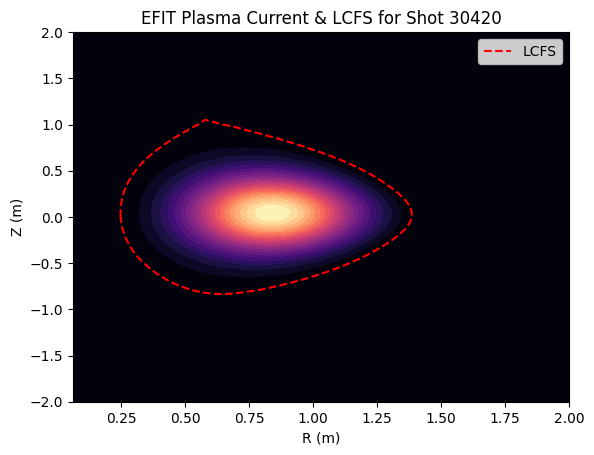

In [5]:
d = dataset['plasma_current_rz'].dropna(dim='time')
r = dataset['r']
z = dataset['z']

lcfs_R = dataset['lcfs_r'].sel(time=d.time)
lcfs_Z = dataset['lcfs_z'].sel(time=d.time)

R, Z = np.meshgrid(r, z)

index = 50
lcfs_r = lcfs_R[index].values
lcfs_r = lcfs_r[~np.isnan(lcfs_r)]
lcfs_z = lcfs_Z[index].values
lcfs_z = lcfs_z[~np.isnan(lcfs_z)]

fig, ax = plt.subplots()
ax.contourf(R, Z, d[index], cmap='magma', levels=20, label='Plasma Current')
ax.plot(lcfs_r, lcfs_z, c='red', linestyle='--', label='LCFS')

plt.title(f'EFIT Plasma Current & LCFS for Shot {d.attrs["shot_id"]}')
plt.ylabel('Z (m)')
plt.xlabel('R (m)')
plt.legend()

## Mirnov Coils

Mirnov coils are primarily used to measure magnetic fluctuations in the plasma. These fluctuations can provide important information about various plasma instabilities. 

They are particularly useful for studying magnetohydrodynamic (MHD) phenomena. MHD activity includes various modes of instabilities, such as kink modes and tearing modes, which can affect plasma confinement and stability.

In [6]:
dataset = catalog.level1.shots(url='s3://mast/level1/shots/29790.zarr', group='xmo')
dataset = dataset.to_dask()
dataset

/Users/rt2549/miniconda3/envs/mast-book/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 101MB
Dimensions:                        (dim_0: 16, dim_1: 2, time: 1400000)
Coordinates:
  * dim_0                          (dim_0) int32 64B 0 1 2 3 4 ... 12 13 14 15
  * dim_1                          (dim_1) int32 8B 0 1
  * time                           (time) float64 11MB -0.1 -0.1 ... 0.6 0.6
Data variables: (12/18)
    devices_d3_acq216_025_channel  (dim_0) int32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    devices_d3_acq216_025_range    (dim_0, dim_1) float32 128B dask.array<chunksize=(16, 2), meta=np.ndarray>
    devices_limit                  (dim_0) float64 128B dask.array<chunksize=(16,), meta=np.ndarray>
    omaha_1lz                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_2lt                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_2lz                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    ...                             ...
    omaha_5lz                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_5ur                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_5ut                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_5uz                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    omaha_6lz                      (time) float32 6MB dask.array<chunksize=(87500,), meta=np.ndarray>
    time1                          (time) float64 11MB dask.array<chunksize=(87500,), meta=np.ndarray>
Attributes:
    description:  Magnetic Field Measurements: OMAHA high frequency Mirnov co...
    file_name:    xmo029790.nc
    format:       CDF
    mds_name:     None
    name:         xmo
    quality:      Not Checked
    shot_id:      29790
    signal_type:  Raw
    source:       xmo
    uda_name:     XMO
    uuid:         ff541ac3-6b1c-5373-8d33-b85fd46bc75b
    version:      -1

Looking at the spectrogram of the dataset can show us information about the MHD modes. Here we are see seveal mode instabilities occuring before the plasma is lost.

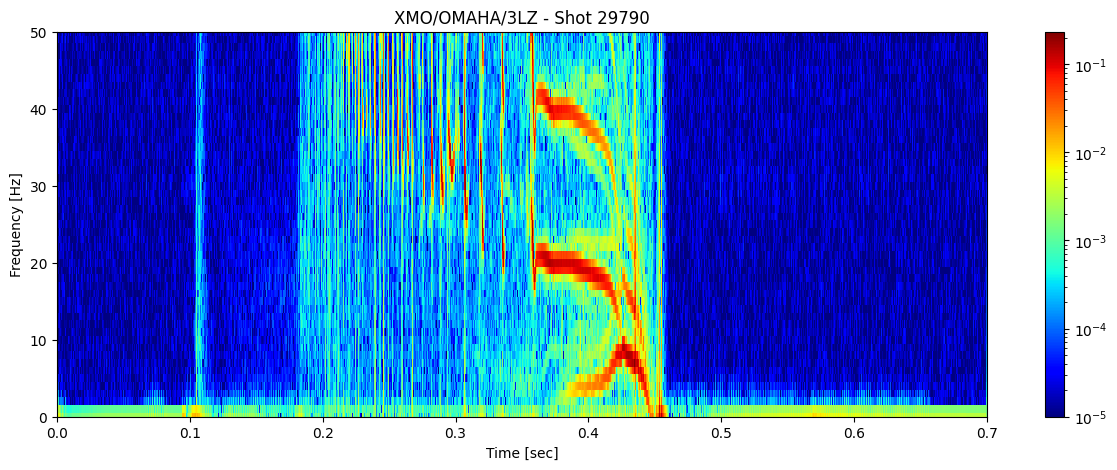

In [7]:
ds = dataset['omaha_3lz']
# Parameters to limit the number of frequencies
nperseg = 2000  # Number of points per segment
nfft = 2000  # Number of FFT points

# Compute the Short-Time Fourier Transform (STFT)
sample_rate = 1/(ds.time[1] - ds.time[0])
f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap='jet', norm=LogNorm(vmin=1e-5))
ax.set_ylim(0, 50)
ax.set_title(f'XMO/OMAHA/3LZ - Shot {ds.attrs["shot_id"]}')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.colorbar(cax, ax=ax)

## Photron Camera Data

### RBA

RBA contains the data from Photron bullet camera A. 

A Photron Bullet Camera provides high-speed, high-resolution imaging of fast transient events in the plasma. Its ability to capture detailed images of plasma instabilities, turbulence, and disruptions makes it essential for understanding and controlling plasma behavior, ultimately aiding in the pursuit of sustained nuclear fusion.

In [8]:
dataset = catalog.level1.shots(url=url, group='rba')
dataset = dataset.to_dask()
dataset

/Users/rt2549/miniconda3/envs/mast-book/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 130MB
Dimensions:  (time: 186, height: 912, width: 768)
Coordinates:
  * time     (time) float64 1kB 0.000256 0.002256 0.004256 ... 0.3093 0.3103
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 130MB dask.array<chunksize=(24, 228, 192), meta=np.ndarray>
Attributes: (12/48)
    CLASS:           IMAGE
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    bottom:          1024
    camera:          
    ...              ...
    units:           pixels
    uuid:            4a073a8f-aa2d-5deb-95df-91f93194c494
    vbin:            0
    version:         -1
    view:            Hl07 floor mount + FFC2 + 25mm lens + CII filter
    width:           768

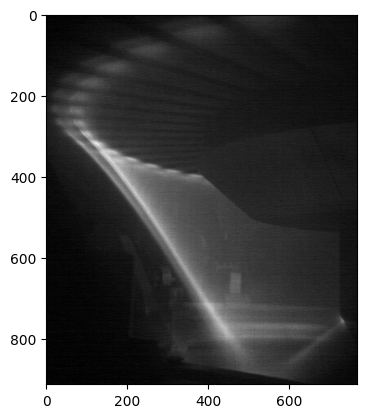

In [9]:
plt.imshow(dataset.data[-10], cmap='gray')

### RBB

RBB contains the data from Photron bullet camera B, which is looking at the central column. 

A Photron Bullet Camera provides high-speed, high-resolution imaging of fast transient events in the plasma. Its ability to capture detailed images of plasma instabilities, turbulence, and disruptions makes it essential for understanding and controlling plasma behavior, ultimately aiding in the pursuit of sustained nuclear fusion.

In [10]:
dataset = catalog.level1.shots(url=url, group='rbb')
dataset = dataset.to_dask()
dataset

<xarray.Dataset> Size: 82MB
Dimensions:  (time: 286, height: 448, width: 640)
Coordinates:
  * time     (time) float64 2kB 1.6e-05 0.002016 0.004016 ... 0.308 0.309 0.31
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 82MB dask.array<chunksize=(72, 112, 160), meta=np.ndarray>
Attributes: (12/48)
    CLASS:           IMAGE
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    bottom:          680
    camera:          
    ...              ...
    units:           pixels
    uuid:            10ed506a-3ac4-5e62-8a6b-25a7abfc3171
    vbin:            0
    version:         -1
    view:            photron HM10 + Dalpha filter
    width:           640

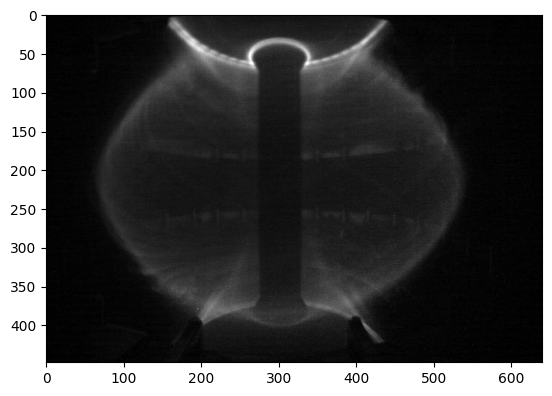

In [11]:
plt.imshow(dataset.data[-10], cmap='gray')